In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
#A = T.scalar()
#B = T.scalar()
A = T.vector('A')
B = T.vector('B')

func = lambda theta, A, B: RosenbrockFunction_Tensor(theta, A, B).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [7]:
options['n_gac'] = 0
lstm_opt = LSTM_Optimizer(params_input=[A, B], **options)
ntm_opt = NTM_BFGS_Optimizer(params_input=[A, B], **options)

In [8]:
lstm_opt.prepare(loss_type='sum', start_lr=0.001)
ntm_opt.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.34139156341552734
Time compiling loss_fn: 4.622509479522705
Time compiling train_fn: 88.27958393096924
Time compiling value_fn: 0.10858368873596191
Time compiling loss_fn: 3.7607924938201904
Time compiling train_fn: 130.18785762786865


In [9]:
train_inputs = multisampler(8000)
val_inputs = multisampler(8000)

In [10]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [14]:
training_options['n_iter'] = 20
    
print("Training LSTM:")
lstm_loss, lstm_val_loss = lstm_opt.train(train_inputs, val_inputs, **training_options)

print("Training NTM:")
ntm_loss, ntm_val_loss = ntm_opt.train(train_inputs, val_inputs, **training_options)

Training LSTM:
Epoch number 0
	Time: 3.030851125717163
	Optimizer loss: 188.72289331054688
	Median final loss: 4.565350532531738
	Validation loss: 48.338437500000005
Epoch number 1
	Time: 3.1674327850341797
	Optimizer loss: 49.335594482421875
	Median final loss: 1.6470685005187988
	Validation loss: 47.50567065429688
Epoch number 2
	Time: 2.934065580368042
	Optimizer loss: 53.963217041015625
	Median final loss: 2.501615524291992
	Validation loss: 56.9817490234375
Epoch number 3
	Time: 2.9579594135284424
	Optimizer loss: 58.03527880859374
	Median final loss: 1.9106388092041016
	Validation loss: 42.192605834960936
Epoch number 4
	Time: 3.051854133605957
	Optimizer loss: 39.605149414062495
	Median final loss: 0.9361050128936768
	Validation loss: 37.57863806152343
Epoch number 5
	Time: 2.9181602001190186
	Optimizer loss: 39.932824096679695
	Median final loss: 1.2060835361480713
	Validation loss: 40.26340942382813
Epoch number 6
	Time: 3.200378894805908
	Optimizer loss: 42.6200859375
	Median

In [15]:
plt.figure(figsize=(15, 12))
for train_loss, val_loss, name in [(lstm_loss, lstm_val_loss, 'lstm'), (ntm_loss, ntm_val_loss, 'ntm')]:
    plt.semilogy(train_loss, label='train_{}'.format(name))
    plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(name))
plt.legend();

In [16]:
from rosenbrock import RosenbrockFunction

AA = T.scalar('a')
BB = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, AA, BB).func

sgd_fn = make_sgd(func_, var=[AA, BB])
momentum_fn = make_momentum(func_, var=[AA, BB])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[AA, BB])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [17]:
lstm_optimizers = {'lstm': lstm_opt, 'ntm': ntm_opt}

In [18]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [19]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; ntm
Testing lstm; lstm
Testing sgd
Testing momentum
Testing lbfgs
Testing lstm; ntm
Testing lstm; lstm
Testing sgd
Testing momentum
Testing lbfgs
Testing lstm; ntm
Testing lstm; lstm
Testing sgd
Testing momentum
Testing lbfgs
Testing lstm; ntm
Testing lstm; lstm
Testing sgd
Testing momentum
Testing lbfgs


In [20]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

In [21]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)

(2.901525603626358, 8.418850828499302)


In [22]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

(-1.2344149910192166, 1.5237803700529726)


In [23]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

(-0.38934589861259816, 0.15159022876645156)


(-1.7131288507825355, 2.934810459383491)


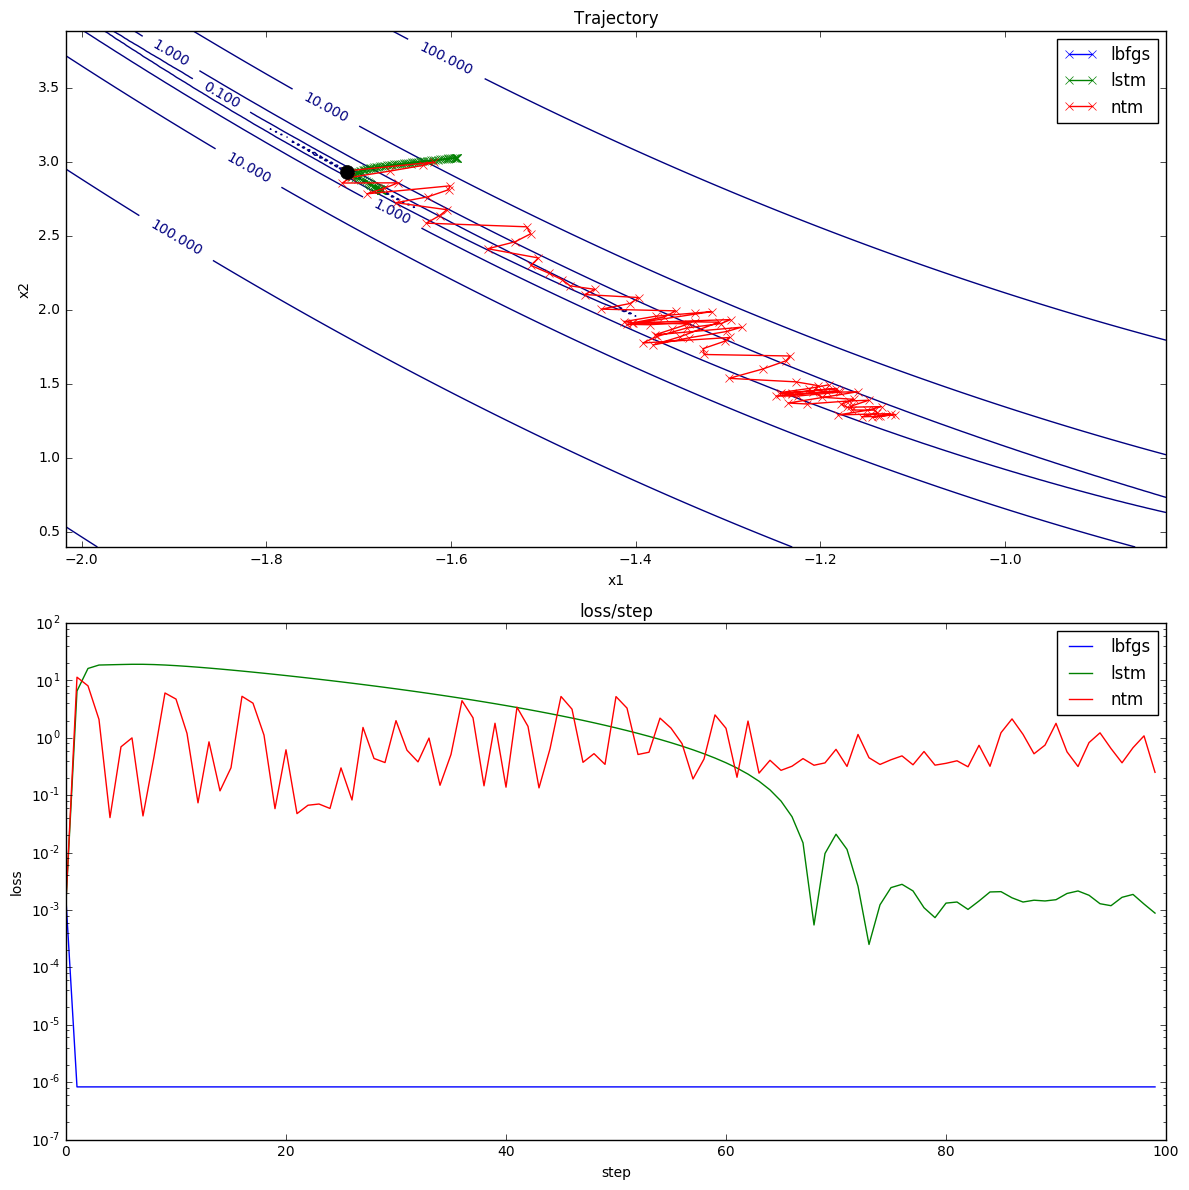

In [24]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})